In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import pdb
import glob
import pandas as pd
import torch
from tqdm import tqdm

In [3]:
import sys
sys.path.append('/home/akumar/nse/localization')

In [4]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_data
from dca_research.kca import calc_mmse_from_cross_cov_mats

In [5]:
from loaders import load_peanut
from utils import calc_loadings, apply_df_filters

In [6]:
fpath = '/media/akumar/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [7]:
with open('../peanut_dca_dimreduc.dat', 'rb') as f:
    dca_dimreduc_df = pickle.load(f)
with open('../peanut_kca_dimreduc.dat', 'rb') as f:
    kca_dimreduc_df = pickle.load(f)
with open('../peanut_dca_decoding_df.dat', 'rb') as f:
    dca_decoding_df = pickle.load(f)
with open('../peanut_kca_decoding_df.dat', 'rb') as f:
    kca_decoding_df = pickle.load(f)

In [12]:
dca_dimreduc_df.iloc[0]

data_file          /media/akumar/Secondary/data/peanut/data_dict_...
loader                                                        peanut
bin_width                                                         25
epoch                                                              2
filter_fn                                                       none
filter_kwargs                                                     {}
boxcox                                                           0.5
spike_threshold                                                  200
dim_vals           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
n_folds                                                            5
T                                                                  3
ols_order                                                          1
data_path                        /media/akumar/Secondary/data/peanut
results_file       /media/akumar/Secondary/data/peanut_dca2/peanu...
dim                               

In [21]:
var_files = glob.glob('/media/akumar/Secondary/data/peanut_var2/peanut_var2_*.dat')
results_list = []
for var_file in var_files:
    result = {}
    with open(var_file, 'rb') as f:
        args = pickle.load(f)
        coefs = pickle.load(f)
        scores_and_supports = pickle.load(f)

    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in args[key].items():
                result[key_] = value_
        else:
            result[key] = value

    result['A'] = np.squeeze(coefs)
    results_list.append(result)
var_df = pd.DataFrame(results_list)

In [10]:
# Plot the localization of loadings

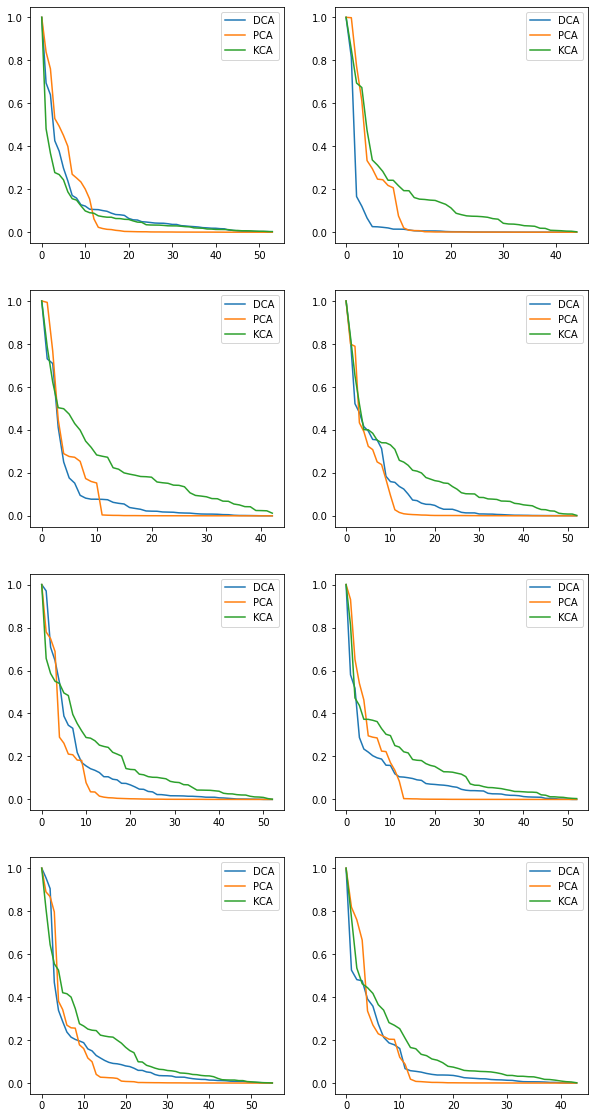

In [11]:
epochs = np.unique(dca_dimreduc_df['epoch'])
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i, epoch in enumerate(epochs):
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=1, fold_idx=1, dim=2)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=1, fold_idx=1)    
    kca_df = apply_df_filters(kca_dimreduc_df, epoch=epoch, dimreduc='KCA', ols_order=1, fold_idx=0, dim=2)

    dca_loadings = calc_loadings(dca_df.iloc[0]['coef'])
    pca_loadings = calc_loadings(pca_df.iloc[0]['coef'][:, 0:2])
    kca_loadings = calc_loadings(kca_df.iloc[0]['coef'])
    
    a = ax[np.unravel_index(i, (4, 2))]
    a.plot(np.sort(dca_loadings)[::-1])
    a.plot(np.sort(pca_loadings)[::-1])
    a.plot(np.sort(kca_loadings)[::-1])
    
    a.legend(['DCA', 'PCA', 'KCA'])

In [154]:
# Final Plot # 1: 1 (a) Localization of DCA Loadings, (b) Lack of correlation between PCA and DCA loadings

In [172]:
import matplotlib.gridspec as gridspec

In [333]:
from matplotlib.ticker import FormatStrFormatter

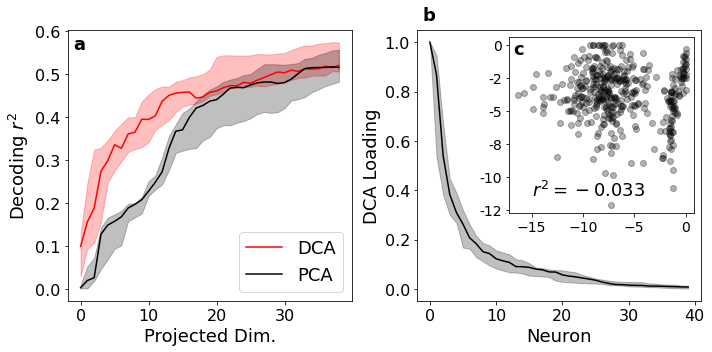

In [334]:
# fig = plt.figure(constrained_layout=True, figsize=(5, 5))
# spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

dca_loadings_sorted = np.zeros((epochs.size, 40))
pca_loadings_sorted = np.zeros((epochs.size, 40))

dca_loadings = []
pca_loadings = []

dca_r2 = []
pca_r2 = []

dim_vals = np.arange(1, 40)

for i, epoch in enumerate(epochs):
    #### Loadings ######
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=1, fold_idx=1, dim=2)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=1, fold_idx=1)
    
    dca_loadings_sorted[i, :] = np.sort(calc_loadings(dca_df.iloc[0]['coef']))[::-1][0:40]
    pca_loadings_sorted[i, :] = np.sort(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2]))[::-1][0:40]

    dca_loadings.extend(calc_loadings(dca_df.iloc[0]['coef']))
    pca_loadings.extend(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2]))
    
    ##### Decoding ######
    dca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='DCA', ols_order=1)
    fold_idxs = np.unique(dca_df['fold_idx'].values)
    dca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(dca_df, dim=dim_val, fold_idx=fold_idx)
            dca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    dca_r2.append(dca_r2_epoch)
    
    pca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='PCA', ols_order=1)
    pca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(pca_df, dim=dim_val, fold_idx=fold_idx)
            pca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    pca_r2.append(pca_r2_epoch)

dca_r2_median = np.median([np.mean(dca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], axis=0)
pca_r2_median = np.median([np.mean(pca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], axis=0)

dca_r2_uquantile = np.quantile([np.mean(dca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], 0.75, axis=0)
dca_r2_lquantile = np.quantile([np.mean(dca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], 0.25, axis=0)

pca_r2_uquantile = np.quantile([np.mean(pca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], 0.75, axis=0)
pca_r2_lquantile = np.quantile([np.mean(pca_r2[i], axis=1)[0:40] for i in [0, 1, 3, 4, 5, 6, 7]], 0.25, axis=0)


ax[0].plot(dca_r2_median, 'r')
ax[0].plot(pca_r2_median, 'k')
ax[0].fill_between(np.arange(39), dca_r2_lquantile, dca_r2_uquantile, alpha=0.25, color='r')
ax[0].fill_between(np.arange(39), pca_r2_lquantile, pca_r2_uquantile, alpha=0.25, color='k')
ax[0].legend(['DCA', 'PCA'], fontsize=18, loc='lower right')
ax[0].set_xlabel('Projected Dim.', fontsize=18)
ax[0].set_ylabel('Decoding ' + r'$r^2$', fontsize=18)
ax[0].tick_params(axis='both', labelsize=16)

ax[1].set_ylabel('DCA Loading', fontsize=18)
ax[1].set_xlabel('Neuron', fontsize=18)
ax[1].plot(np.median(dca_loadings_sorted, axis=0), color='k')
ax[1].fill_between(np.arange(40), np.quantile(dca_loadings_sorted, 0.75, axis=0), 
                 np.quantile(dca_loadings_sorted, 0.25, axis=0), 
                 alpha=0.25, color='k')
ax[1].tick_params(axis='both', labelsize=16)


ax2 = ax[1].inset_axes(bounds=(0.325, 0.325, 0.65, 0.65))
ax2.scatter(np.log(pca_loadings), np.log(dca_loadings), color='k', alpha=0.3)
r2 = scipy.stats.spearmanr(pca_loadings, dca_loadings)[0]
ax2.text(-15, -11.5, r'$r^2=%.3f$' % r2, fontsize=18)

ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax2.set_ylabel('Log DCA Loading', fontsize=14)
# ax2.set_xlabel('Log PCA Loading', fontsize=14)


ax[0].text(0.02, 0.98, 'a', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='top')    
ax[1].text(0.02, 1.02, 'b', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax2.text(0.02, 0.98, 'c', transform=ax2.transAxes, fontsize=18, 
         fontweight='bold', va='top')
fig.tight_layout()
#fig.subplots_adjust(wspace=0.45, hspace=0.325)
fig.savefig('aim1fig1.pdf', bbox_inches='tight', pad_inches=0)

In [12]:
# Decoding vs. dimension
epochs = np.unique(dca_decoding_df['epoch'].values)

dca_r2 = []
pca_r2 = []
kca_r2 = []

dim_vals = np.arange(1, 40)
for i, epoch in enumerate(epochs):
    
    dca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='DCA', ols_order=1)
    fold_idxs = np.unique(dca_df['fold_idx'].values)
    dca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(dca_df, dim=dim_val, fold_idx=fold_idx)
            dca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    dca_r2.append(dca_r2_epoch)
    
    pca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='PCA', ols_order=1)
    pca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(pca_df, dim=dim_val, fold_idx=fold_idx)
            pca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    pca_r2.append(pca_r2_epoch)

    
    kca_df = apply_df_filters(kca_decoding_df, epoch=epoch, dr_method='KCA', ols_order=1)
    fold_idxs = np.unique(dca_df['fold_idx'].values)
    kca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(kca_df, dim=dim_val, fold_idx=fold_idx)
            try:
                kca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
            except:
                pdb.set_trace()
    kca_r2.append(kca_r2_epoch)

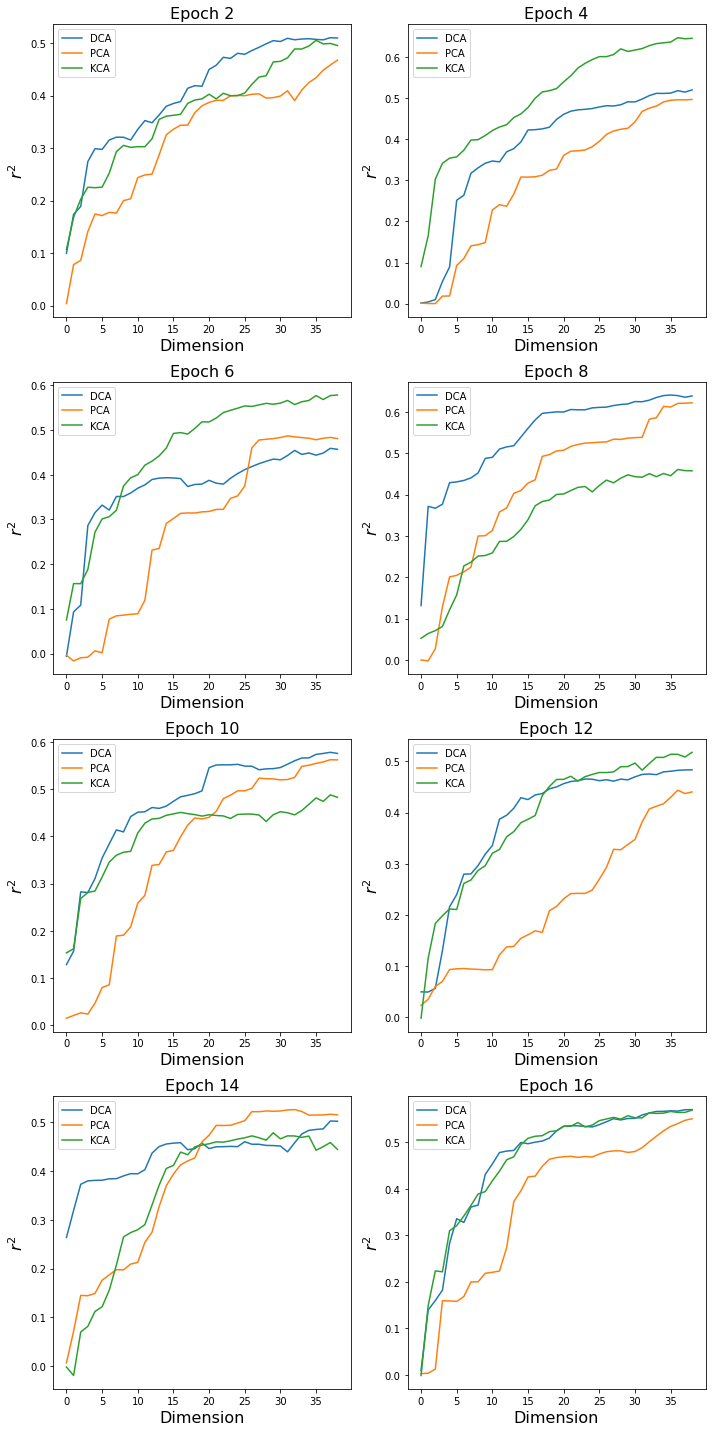

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))

for i, epoch in enumerate(epochs):
    
    a = ax[np.unravel_index(i, (4, 2))]
    a.plot(np.mean(dca_r2[i], axis=1))
    a.plot(np.mean(pca_r2[i], axis=1))
    a.plot(np.mean(kca_r2[i], axis=1))
    a.set_title('Epoch %d' % epoch, fontsize=16)
    a.set_xlabel('Dimension', fontsize=16)
    a.set_ylabel(r'$r^2$', fontsize=16)
    a.legend(['DCA', 'PCA', 'KCA'])
fig.tight_layout()

In [43]:
pca_Pmintrace = []
dca_Pmintrace = []
kca_Pmintrace = []

pca_mmse = []
dca_mmse = []
kca_mmse = []

for i, epoch in enumerate(epochs):
    
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=1, fold_idx=1, dim=2)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=1, fold_idx=1)
    kca_df = apply_df_filters(kca_dimreduc_df, epoch=epoch, dimreduc='KCA', ols_order=1, fold_idx=1, dim=2)
    
    var_df_ = apply_df_filters(var_df, epoch=epoch)

    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                      filter_fn='none')

    cv = KFold(5, shuffle=False)
    train_idxs, test_idxs = next(cv.split(np.squeeze(dat['spike_rates'])))
    C1 = dca_df.iloc[0]['coef']
    C2 = pca_df.iloc[0]['coef'][:, 0:2]
    C3 = kca_df.iloc[0]['coef']
    
    ssr1 = SSR(A=var_df_.iloc[0]['A'], B = np.eye(var_df_.iloc[0]['A'].shape[0]), C=C1.T)
    ssr1.solve_min_phase()
    ssr2 = SSR(A=var_df_.iloc[0]['A'], B = np.eye(var_df_.iloc[0]['A'].shape[0]), C=C2.T)
    ssr2.solve_min_phase()
    ssr3 = SSR(A=var_df_.iloc[0]['A'], B = np.eye(var_df_.iloc[0]['A'].shape[0]), C=C3.T)
    ssr3.solve_min_phase()

    
    pca_Pmintrace.append(np.trace(ssr1.P - ssr1.Pmin))
    dca_Pmintrace.append(np.trace(ssr2.P - ssr2.Pmin))
    kca_Pmintrace.append(np.trace(ssr3.P - ssr3.Pmin))
    
    # Normalize
    X = np.squeeze(dat['spike_rates'])[train_idxs, :]
    #X = StandardScaler().fit_transform(X)
    cross_cov_mats = calc_cross_cov_mats_from_data(X, T=6)
        
    pca_mmse.append(calc_mmse_from_cross_cov_mats(torch.tensor(cross_cov_mats), proj=torch.tensor(C1)))
    dca_mmse.append(calc_mmse_from_cross_cov_mats(torch.tensor(cross_cov_mats), proj=torch.tensor(C2)))
    kca_mmse.append(calc_mmse_from_cross_cov_mats(torch.tensor(cross_cov_mats), proj=torch.tensor(C3)))

In [42]:
# KCA works...

[Text(1, 0, 'Improvement over PCA'), Text(2, 0, 'Improvement over DCA')]

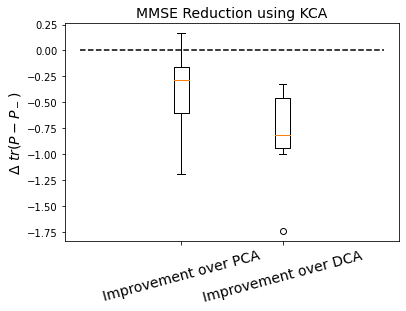

In [69]:
fig, ax = plt.subplots()
ax.boxplot([np.array(kca_Pmintrace) - np.array(pca_Pmintrace),
             np.array(kca_Pmintrace) - np.array(dca_Pmintrace)])
ax.hlines(0, 0, 3, linestyle='--', color='k')
ax.set_title('MMSE Reduction using KCA', fontsize=14)
ax.set_ylabel(r'$\Delta$ ' + r'$tr(P - P_-)$', fontsize=14)
ax.set_xticklabels(['Improvement over PCA', 'Improvement over DCA'], fontsize=14, rotation=15)

In [86]:
pca_loadings = []
dca_loadings = []
kca_loadings = []
su_var = []
su_pi = []
su_var_model = []
su_pi_model = []
su_Pmintrace = []
su_mmse = []

for i, epoch in tqdm(enumerate(epochs)):
    
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=1, fold_idx=1, dim=2)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=1, fold_idx=1)
    kca_df = apply_df_filters(kca_dimreduc_df, epoch=epoch, dimreduc='KCA', ols_order=1, fold_idx=1, dim=2)
    var_df_ = apply_df_filters(var_df, epoch=epoch)

    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                      filter_fn='none')

    cv = KFold(5, shuffle=False)
    train_idxs, test_idxs = next(cv.split(np.squeeze(dat['spike_rates'])))
    X = np.squeeze(dat['spike_rates'])[train_idxs, :]
    # X = StandardScaler().fit_transform(X)
    cross_cov_mats = calc_cross_cov_mats_from_data(X, T=6)
    ccmt = torch.tensor(cross_cov_mats)
    C1 = dca_df.iloc[0]['coef']
    C2 = pca_df.iloc[0]['coef'][:, 0:2]
    C3 = kca_df.iloc[0]['coef']

    dca_loadings.extend(calc_loadings(C1))
    pca_loadings.extend(calc_loadings(C2))
    kca_loadings.extend(calc_loadings(C3))
    su_var.extend(np.var(X, axis=0))
    for j in range(X.shape[1]):
        C = np.zeros((1, X.shape[1]))
        C[0, j] = 1
        ssr = SSR(A=var_df_.iloc[0]['A'], B = np.eye(var_df_.iloc[0]['A'].shape[0]), C=C)
        ssr.solve_min_phase()
        su_pi.append(calc_pi_from_data(X, T=3, proj=C.T))
        su_pi_model.append(ssr.pi(3))
        su_var_model.append(ssr.cov[0][0])
        su_Pmintrace.append(np.trace(ssr.Pmin)) 
        Ct = torch.tensor(C.T)
        su_mmse.append(calc_mmse_from_cross_cov_mats(ccmt, Ct).numpy())

8it [00:33,  4.25s/it]


In [244]:
# Save these away for plotting below
pca_su_var_r2 = scipy.stats.spearmanr(pca_loadings, su_var)[0]
dca_su_var_r2 = scipy.stats.spearmanr(dca_loadings, su_var)[0]
pca_su_pi_r2  = scipy.stats.spearmanr(pca_loadings, su_pi)[0]
dca_su_pi_r2 = scipy.stats.spearmanr(dca_loadings, su_pi)[0]
pca_su_mmse_r2 = scipy.stats.spearmanr(pca_loadings, su_Pmintrace)[0]
dca_su_mmse_r2 = scipy.stats.spearmanr(dca_loadings, su_Pmintrace)[0]

In [245]:
pca_su_var_r2

0.9177610204736683

In [246]:
dca_su_var_r2

-0.05225308518799382

In [247]:
pca_su_pi_r2

-0.10556918913151944

In [248]:
dca_su_pi_r2

0.4971349951033269

In [ ]:
# Correlation between DCA, PCA, and KCA loadings

Text(0.5, 1.0, '$r^2 = 0.336$')

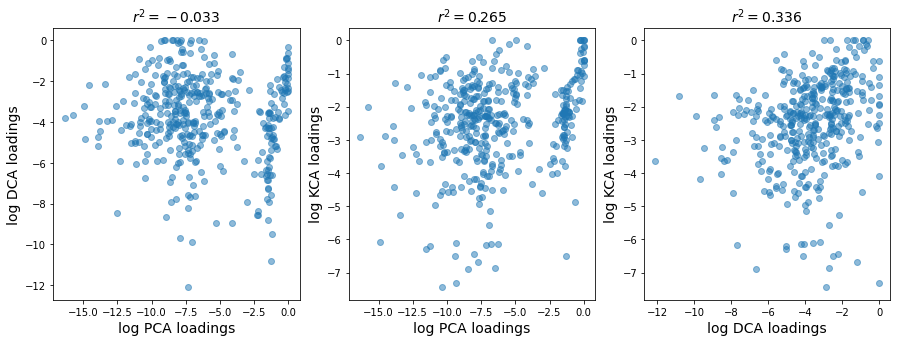

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(np.log(pca_loadings), np.log(dca_loadings), alpha=0.5)
ax[0].set_xlabel('log PCA loadings', fontsize=14)
ax[0].set_ylabel('log DCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(pca_loadings, dca_loadings)[0]
ax[0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)

ax[1].scatter(np.log(pca_loadings), np.log(kca_loadings), alpha=0.5)
ax[1].set_xlabel('log PCA loadings', fontsize=14)
ax[1].set_ylabel('log KCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(pca_loadings, kca_loadings)[0]
ax[1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)

ax[2].scatter(np.log(dca_loadings), np.log(kca_loadings), alpha=0.5)
ax[2].set_xlabel('log DCA loadings', fontsize=14)
ax[2].set_ylabel('log KCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(dca_loadings, kca_loadings)[0]
ax[2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)


In [ ]:
# Correlation between PCA, DCA, and KCA loadings and single unit MMSE (model derived)

(-10.0, 0.0)

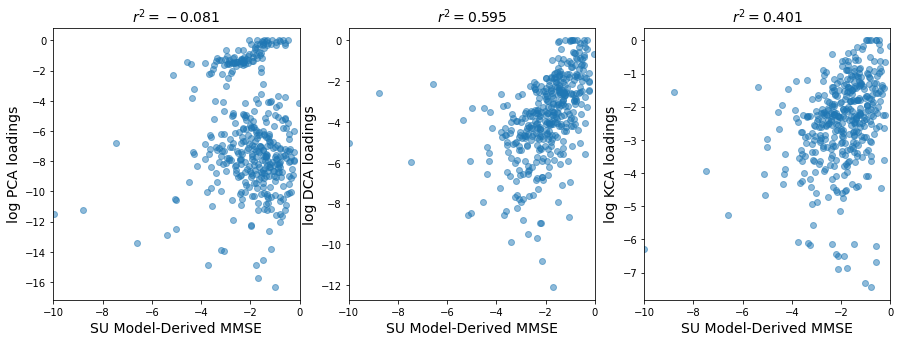

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(np.log(su_Pmintrace), np.log(pca_loadings), alpha=0.5)
ax[0].set_xlabel('SU Model-Derived MMSE', fontsize=14)
ax[0].set_ylabel('log PCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_Pmintrace, pca_loadings)[0]
ax[0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[0].set_xlim([-10, 0])

ax[1].scatter(np.log(su_Pmintrace), np.log(dca_loadings), alpha=0.5)
ax[1].set_xlabel('SU Model-Derived MMSE', fontsize=14)
ax[1].set_ylabel('log DCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_Pmintrace, dca_loadings)[0]
ax[1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[1].set_xlim([-10, 0])


ax[2].scatter(np.log(su_Pmintrace), np.log(kca_loadings), alpha=0.5)
ax[2].set_xlabel('SU Model-Derived MMSE', fontsize=14)
ax[2].set_ylabel('log KCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_Pmintrace, kca_loadings)[0]
ax[2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[2].set_xlim([-10, 0])

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


(-10.0, 0.0)

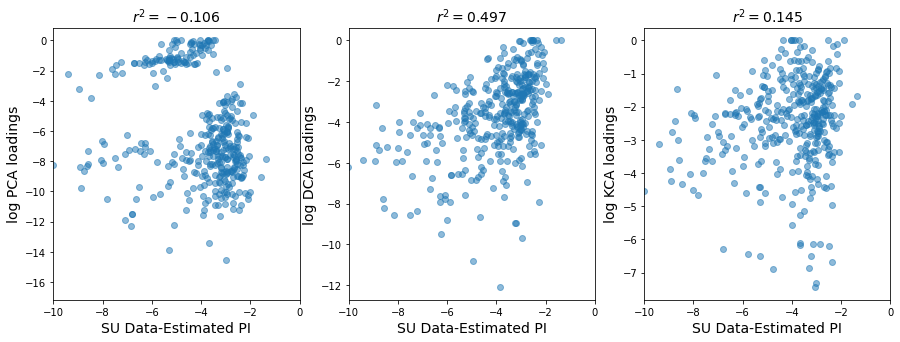

In [98]:
# Do the same thing with PI
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(np.log(su_pi), np.log(pca_loadings), alpha=0.5)
ax[0].set_xlabel('SU Data-Estimated PI', fontsize=14)
ax[0].set_ylabel('log PCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi, pca_loadings)[0]
ax[0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[0].set_xlim([-10, 0])

ax[1].scatter(np.log(su_pi), np.log(dca_loadings), alpha=0.5)
ax[1].set_xlabel('SU Data-Estimated PI', fontsize=14)
ax[1].set_ylabel('log DCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi, dca_loadings)[0]
ax[1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[1].set_xlim([-10, 0])


ax[2].scatter(np.log(su_pi), np.log(kca_loadings), alpha=0.5)
ax[2].set_xlabel('SU Data-Estimated PI', fontsize=14)
ax[2].set_ylabel('log KCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi, kca_loadings)[0]
ax[2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[2].set_xlim([-10, 0])

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


(-10.0, 0.0)

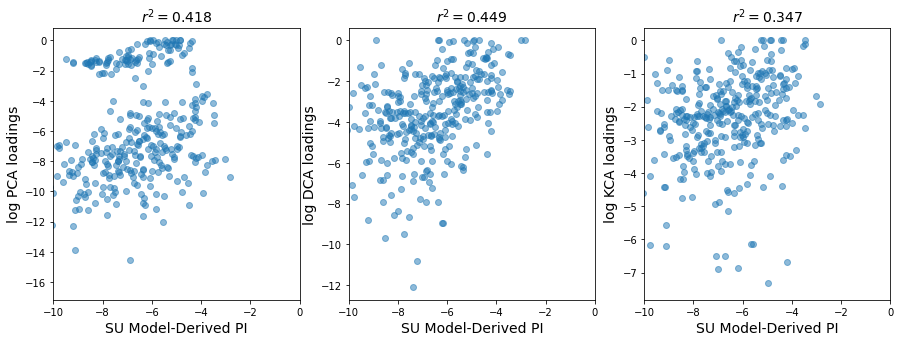

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(np.log(su_pi_model), np.log(pca_loadings), alpha=0.5)
ax[0].set_xlabel('SU Model-Derived PI', fontsize=14)
ax[0].set_ylabel('log PCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi_model, pca_loadings)[0]
ax[0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[0].set_xlim([-10, 0])

ax[1].scatter(np.log(su_pi_model), np.log(dca_loadings), alpha=0.5)
ax[1].set_xlabel('SU Model-Derived PI', fontsize=14)
ax[1].set_ylabel('log DCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi_model, dca_loadings)[0]
ax[1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[1].set_xlim([-10, 0])


ax[2].scatter(np.log(su_pi_model), np.log(kca_loadings), alpha=0.5)
ax[2].set_xlabel('SU Model-Derived PI', fontsize=14)
ax[2].set_ylabel('log KCA loadings', fontsize=14)
r2_ = scipy.stats.spearmanr(su_pi_model, kca_loadings)[0]
ax[2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
ax[2].set_xlim([-10, 0])

In [ ]:
# Calculate correlation with decoder/encoder weights

In [205]:
from decoders import lr_decoder, lr_encoder

In [212]:
decoder_params = {'trainlag': 0, 'testlag': 0, 'decoding_window': 6}
fold_idx = 1

result = {}
for i, epoch in tqdm(enumerate(epochs)):
    
    result[epoch] = {}
    
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=1, fold_idx=1)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=1, fold_idx=1)
    
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                      filter_fn='none')
    
    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']

    kfold = KFold(n_splits=5, shuffle=False)
    train_idxs, test_idxs = list(kfold.split(X))[fold_idx]
    ztrain = Z[train_idxs, :]
    ztest = Z[test_idxs, :]

    # Population level decoding/encoding - use the coefficient in the linear fit
    # Record both the weights in the coefficient but also the loadings onto the SVD

    xtrain = X[train_idxs, :]
    xtest = X[test_idxs, :]
    
    _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
    _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

    result[epoch]['decoding_weights'] = decodingregressor.coef_
    result[epoch]['encoding_weights'] = encodingregressor.coef_
    
    u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:1, :], full_matrices=False)
    u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)
    
    result[epoch]['decoding_pos_svd'] = vh1
    result[epoch]['encoding_svd'] = u4
    
    r2_pos_decoding = []
    r2_encoding = []
    
    decoding_weights = []
    encoding_weights = []
    
    decoding_weights_svd = []
    encoding_weights_svd = []
    
    
    for neu_idx in range(X.shape[1]):           #Fit all neurons one by one
        
        xtrain = X[train_idxs, neu_idx][:, np.newaxis]
        xtest = X[test_idxs, neu_idx][:, np.newaxis]
        # Decoding
        r2_pos, _, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_pos_decoding.append(r2_pos)        
        decoding_weights.append(dr.coef_)
        
        # Encoding
        r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        r2_encoding.append(r2_encoding_)
        encoding_weights.append(er.coef_)        
        
    result[epoch]['su_r2_pos_decoding'] = r2_pos_decoding
    result[epoch]['su_r2_encoding'] = r2_encoding
    result[epoch]['su_decoding_weight'] = decoding_weights
    result[epoch]['su_encoding_weight'] = encoding_weights        
    
    dim_vals = np.arange(2, 41)
    dca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    pca_loadings = np.zeros((dim_vals.size, X.shape[1]))
    
    for i, dim_ in enumerate(dim_vals):
        dca_df_ = dca_df.loc[dca_df['dim'] == dim_]
        dca_loadings[i, :] = calc_loadings(dca_df_.iloc[0]['coef'])
        pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['coef'][:, 0:dim_])
    
    result[epoch]['dca_loadings'] = dca_loadings
    result[epoch]['pca_loadings'] = pca_loadings

8it [00:30,  3.80s/it]


In [224]:
# For each quantity, calculate the spearman r2 
dca_decoding_weightsr2 = np.zeros(dim_vals.size)
dca_decoding_svdr2 = np.zeros(dim_vals.size)
pca_decoding_weightsr2 = np.zeros(dim_vals.size)
pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_dca.extend(result[epoch]['dca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[epoch]['decoding_weights'][0, :][np.newaxis, :].T, 6))
        x2.extend(calc_loadings(result[epoch]['decoding_pos_svd'].T, 6))

    dca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

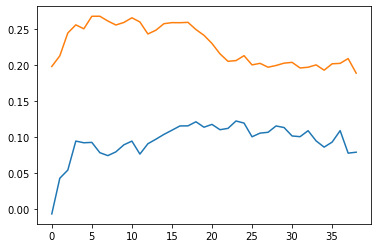

In [226]:
plt.plot(dca_decoding_weightsr2)
plt.plot(pca_decoding_weightsr2)

In [228]:
# For each quantity, calculate the spearman r2 
dca_encoding_weightsr2 = np.zeros(dim_vals.size)
dca_encoding_svdr2 = np.zeros(dim_vals.size)
pca_encoding_weightsr2 = np.zeros(dim_vals.size)
pca_encoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_dca.extend(result[epoch]['dca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[epoch]['encoding_weights'], 1))
        x2.extend(calc_loadings(result[epoch]['encoding_svd'], 1))

    dca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    dca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    pca_encoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    pca_encoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

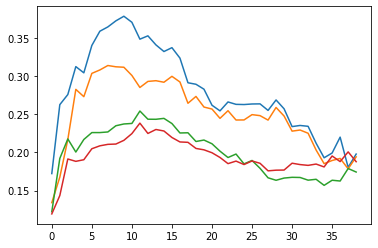

In [229]:
plt.plot(dca_encoding_weightsr2)
plt.plot(dca_encoding_svdr2)
plt.plot(pca_encoding_weightsr2)
plt.plot(pca_encoding_svdr2)

In [235]:
np.argmax(dca_encoding_weightsr2)

9

In [230]:
# For each quantity, calculate the spearman r2 
dca_suposweight_r2 = np.zeros(dim_vals.size)
pca_suposweight_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    
    for epoch in epochs:
        y_dca.extend(result[epoch]['dca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[epoch]['su_decoding_weight'][idx][0, :])
                   for idx in range(len(result[epoch]['su_decoding_weight']))])

    dca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]    
    pca_suposweight_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

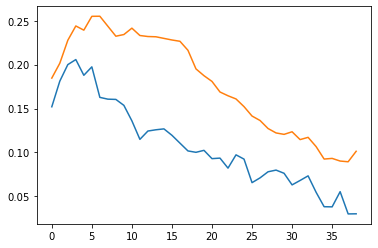

In [231]:
plt.plot(dca_suposweight_r2)
plt.plot(pca_suposweight_r2)

In [232]:
# For each quantity, calculate the spearman r2 
dca_suencoding_r2 = np.zeros(dim_vals.size)
pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for epoch in epochs:
        y_dca.extend(result[epoch]['dca_loadings'][i, :])
        y_pca.extend(result[epoch]['pca_loadings'][i, :])
        
        x1.extend([np.linalg.norm(result[epoch]['su_encoding_weight'][idx])
                   for idx in range(len(result[epoch]['su_encoding_weight']))])

    dca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

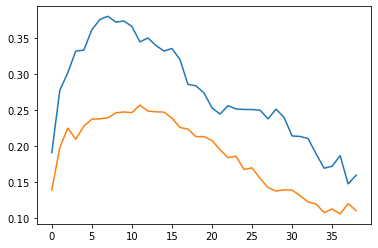

In [233]:
plt.plot(dca_suencoding_r2)
plt.plot(pca_suencoding_r2)

In [236]:
# Use the population decoding and encoding weights in the bar chart. Use dim=10

In [266]:
X_axis

array([0. , 0.5, 1. , 1.5, 2. ])

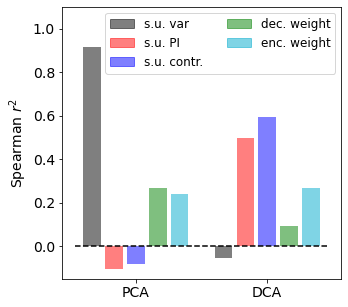

In [317]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = ['k', 'r', 'blue', 'green', '#00aacc']

# Save these away for plotting below
pca_x = [pca_su_var_r2, pca_su_pi_r2, pca_su_mmse_r2, pca_decoding_weightsr2[10], pca_encoding_weightsr2[10]]
dca_x = [dca_su_var_r2, dca_su_pi_r2, dca_su_mmse_r2, dca_decoding_weightsr2[10], pca_decoding_weightsr2[10]]

bar_width = 0.4
X_axis = np.linspace(0, len(pca_x) * bar_width, len(pca_x))
  
ax.bar(X_axis, pca_x, bar_width, label = 'PCA', alpha=0.5, color=colors)
ax.bar(X_axis + X_axis[-1] + 1, dca_x, bar_width, label = 'DCA', alpha=0.5, color=colors)

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_ylim([-0.15, 1.1])

ax.set_xticks([X_axis[2], X_axis[2] + X_axis[-1] + 1])
ax.set_xticklabels(['PCA', 'DCA'], fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Spearman ' + r'$r^2$', fontsize=14)

ax.hlines(0, -0.4,  2 * X_axis[-1] + 1.4, linestyle='--', color='k')

handles = [plt.Rectangle((0,0),1,1, color=color_) for color_ in colors]
leg = ax.legend(handles, ['s.u. var', 's.u. PI', 's.u. contr.', 'dec. weight', 'enc. weight'],
                ncol=2, fontsize=12)
for lh in leg.legendHandles: 
    lh.set_alpha(0.5)

fig.savefig('aim1fig2.pdf', bbox_inches='tight', pad_inches=0)

### Do these replicate from random networks

In [102]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from dca_research.kca import KalmanComponentsAnalysis as KCA
from sklearn.decomposition import PCA

In [131]:
A = 1/(3 * np.sqrt(reps * density[i])) * \
            np.multiply(np.random.normal(size=(size, size)), np.random.binomial(1, density[i], size=(size, size)))

In [132]:
np.max(np.abs(np.linalg.eigvals(A)))

0.8555220636562957

In [142]:
density = np.linspace(0.2, 1, 10)
reps = 50
size = 50

pca_loadings = []
dca_loadings = []
kca_loadings = []

su_pi = []
su_mmse = []

for i in tqdm(range(density.size)):
    pca_loadings.append([])
    dca_loadings.append([])
    kca_loadings.append([])

    su_pi.append([])
    su_mmse.append([])
    
    for j in range(reps):
        A = 1/(3 * np.sqrt(reps * density[i])) * \
                    np.multiply(np.random.normal(size=(size, size)), 
                                np.random.binomial(1, density[i], size=(size, size)))        
        while max(np.abs(np.linalg.eigvals(A)) > 0.99):
            A = 1/(3 * np.sqrt(reps * density[i])) * \
                        np.multiply(np.random.normal(size=(size, size)), 
                                    np.random.binomial(1, density[i], size=(size, size)))        
        ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
        
        x = ssr.trajectory(int(1e4), burnoff=True)
        dcamodel = DCA(d=2, T=3)
        kcamodel = KCA(d=2, T=6)
        pcamodel = PCA()
        
        dcamodel.fit(x)
        kcamodel.fit(x)
        pcamodel.fit(x)
        
        dca_loadings[i].extend(calc_loadings(dcamodel.coef_))
        kca_loadings[i].extend(calc_loadings(kcamodel.coef_))
        pca_loadings[i].extend(calc_loadings(pcamodel.components_.T[:, 0:2]))
        
        for k in range(size):
            C = np.zeros((1, size))
            C[0, k] = 1
            ssr_su = SSR(A = A, B=np.eye(A.shape[0]), C=C)
            ssr_su.solve_min_phase()
            
            su_pi[i].append(ssr_su.pi(3))
            su_mmse[i].append(np.trace(ssr_su.Pmin))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:09<00:00, 24.92s/it]


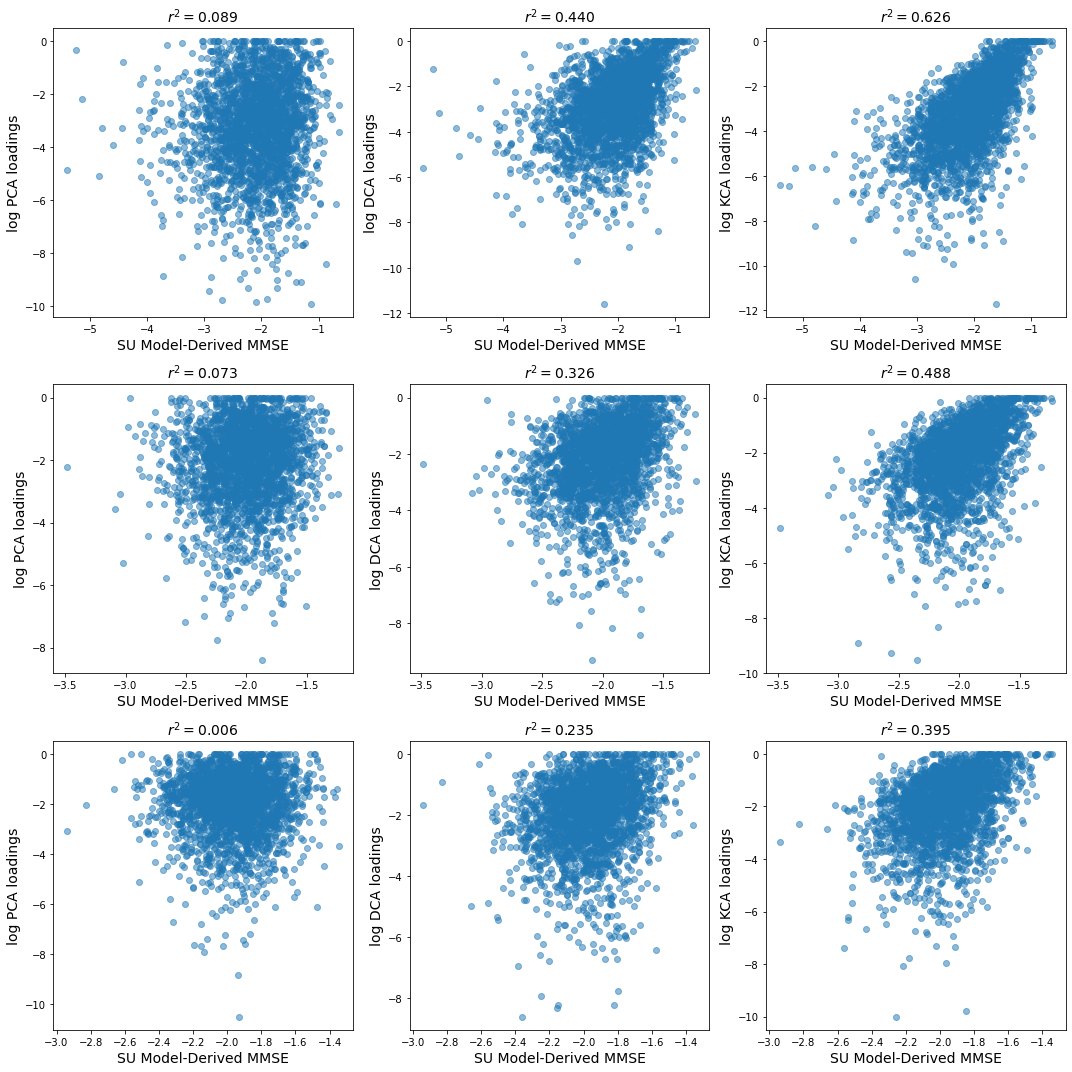

In [148]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

idxs = [0, 5, 9]
for i, idx in enumerate(idxs):
    ax[i, 0].scatter(np.log(su_mmse[idx]), np.log(pca_loadings[idx]), alpha=0.5)
    ax[i, 0].set_xlabel('SU Model-Derived MMSE', fontsize=14)
    ax[i, 0].set_ylabel('log PCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_mmse[idx], pca_loadings[idx])[0]
    ax[i, 0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    #ax[i, 0].set_xlim([-10, 0])

    ax[i, 1].scatter(np.log(su_mmse[idx]), np.log(dca_loadings[idx]), alpha=0.5)
    ax[i, 1].set_xlabel('SU Model-Derived MMSE', fontsize=14)
    ax[i, 1].set_ylabel('log DCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_mmse[idx], dca_loadings[idx])[0]
    ax[i, 1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    #ax[i, 1].set_xlim([-10, 0])


    ax[i, 2].scatter(np.log(su_mmse[idx]), np.log(kca_loadings[idx]), alpha=0.5)
    ax[i, 2].set_xlabel('SU Model-Derived MMSE', fontsize=14)
    ax[i, 2].set_ylabel('log KCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_mmse[idx], kca_loadings[idx])[0]
    ax[i, 2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    #ax[i, 2].set_xlim([-10, 0])
fig.tight_layout()

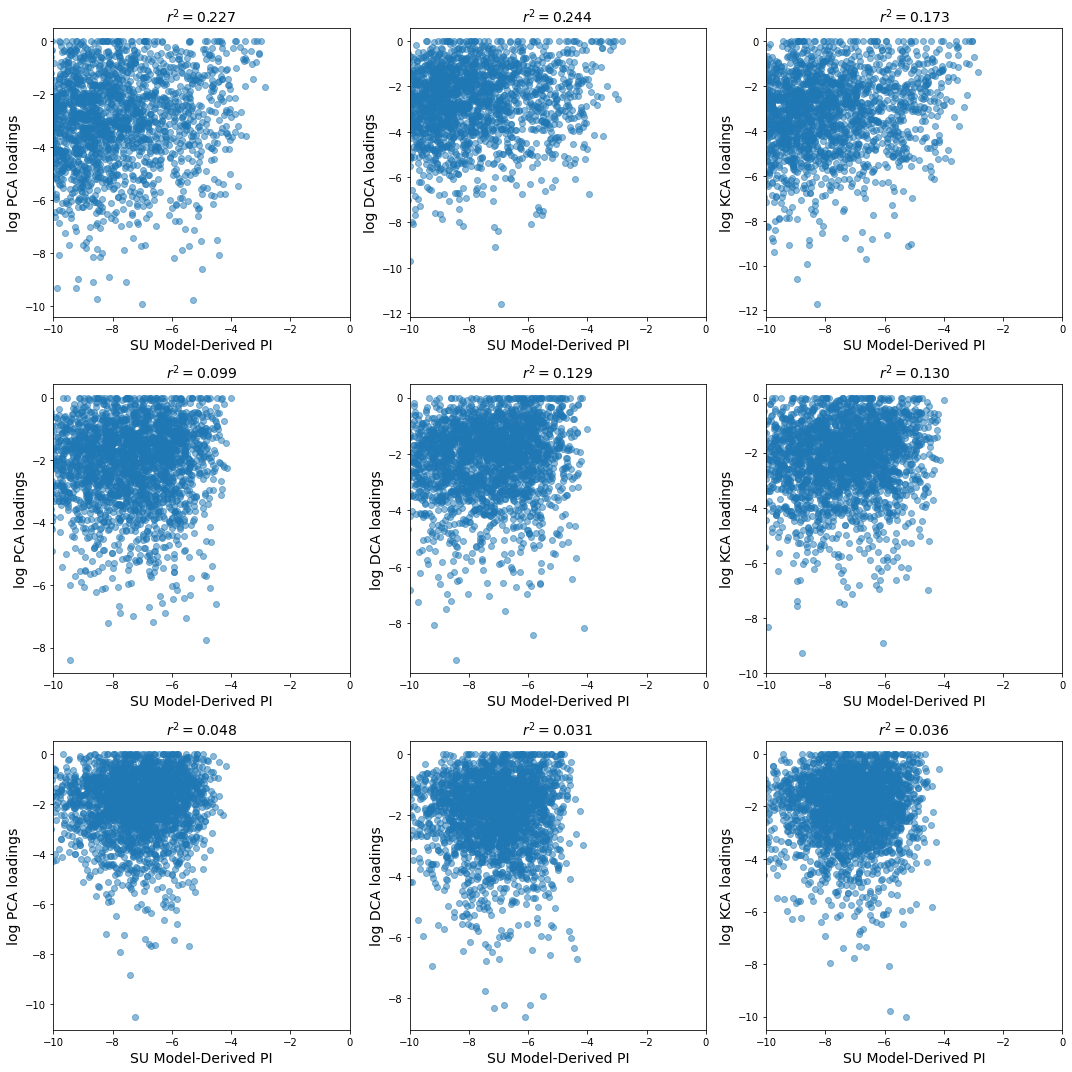

In [150]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
idxs = [0, 5, 9]
for i, idx in enumerate(idxs):
    ax[i, 0].scatter(np.log(su_pi[idx]), np.log(pca_loadings[idx]), alpha=0.5)
    ax[i, 0].set_xlabel('SU Model-Derived PI', fontsize=14)
    ax[i, 0].set_ylabel('log PCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_pi[idx], pca_loadings[idx])[0]
    ax[i, 0].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    ax[i, 0].set_xlim([-10, 0])

    ax[i, 1].scatter(np.log(su_pi[idx]), np.log(dca_loadings[idx]), alpha=0.5)
    ax[i, 1].set_xlabel('SU Model-Derived PI', fontsize=14)
    ax[i, 1].set_ylabel('log DCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_pi[idx], dca_loadings[idx])[0]
    ax[i, 1].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    ax[i, 1].set_xlim([-10, 0])


    ax[i, 2].scatter(np.log(su_pi[idx]), np.log(kca_loadings[idx]), alpha=0.5)
    ax[i, 2].set_xlabel('SU Model-Derived PI', fontsize=14)
    ax[i, 2].set_ylabel('log KCA loadings', fontsize=14)
    r2_ = scipy.stats.spearmanr(su_pi[idx], kca_loadings[idx])[0]
    ax[i, 2].set_title('$r^2 = %.3f$' % r2_, fontsize=14)
    ax[i, 2].set_xlim([-10, 0])
    
fig.tight_layout()

### DCA Loading self consistency

In [375]:
from dca.dca import DynamicalComponentsAnalysis as DCA
from neurosim.models.ssr import StateSpaceRealization as SSR
from sklearn.model_selection import KFold
import torch
from tqdm import tqdm

In [371]:
train_idxs, test_idxs = list(KFold(n_splits=5).split(X))[1]

In [395]:
# Run DCA on autocorrelations sequences generated from the network models and evaluate self consistency
empirical_loadings = []
model_loadings = []

for epoch in tqdm(epochs):
    dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                  filter_fn='none')
    X = np.squeeze(dat['spike_rates'])[train_idxs, :]
    df_ = apply_df_filters(var_df, epoch=epoch)
    A = df_.iloc[0]['A']
    dcamodel = DCA(T=1, d=2)
    dcamodel.estimate_data_statistics(X)
    # Run 10 instances of DCA on the empirical data 
    coef1 = np.zeros((10, X.shape[1], 2))
    for i in range(10):
        v, _ = dcamodel._fit_projection()
        coef1[i, ...] = v
    # Run 10 instances on the model generated data
    coef2 = np.zeros((10, X.shape[1], 2))
    ssr = SSR(A = A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
    dcamodel.cross_covs = torch.tensor(ssr.autocorrelation(10))
    for i in range(10):
        v, _ = dcamodel._fit_projection()
        coef2[i, ...] = v
    
    empirical_loadings_ = np.array([calc_loadings(coef1[j, ...]) for j in range(coef1.shape[0])])
    model_loadings_ = np.array([calc_loadings(coef2[j, ...]) for j in range(coef2.shape[0])])
    
    empirical_loadings.append(empirical_loadings_)
    model_loadings.append(model_loadings_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.28s/it]


In [396]:
# Pairwise maximum spearman r2

In [397]:
spearman_r2 = np.zeros((len(epochs), 10, 10))
for i in range(len(epochs)):
    for j in range(10):
        for k in range(10):
            spearman_r2[i, j, k] = scipy.stats.spearmanr(empirical_loadings[i][j, :],
                                                         model_loadings[i][k, :])[0]

In [408]:
eloadings = []
for loading in empirical_loadings

0.5958890396242605

### Subspace visualization

In [644]:
# For epoch 8, project onto the first 3 DC and PC subspaces and plot the trajectories segmented

In [336]:
tpath = '/media/akumar/Secondary/data/peanut/trajectory_dict_peanut_day14.obj'

In [412]:
from loaders import load_peanut_segmented
from dca.dca import DynamicalComponentsAnalysis as DCA
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter1d

In [645]:
epoch = 8
dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=25, filter_fn='none')
dat_segmented = load_peanut_segmented(tpath, fpath, epoch, spike_threshold=200, bin_width=10)

In [647]:
X = np.squeeze(dat['spike_rates'])

In [642]:
# Fit DCA d = 3 to the entire time series, with movement threshold in play

In [648]:
dcamodel = DCA(T=3, d=3)
dcamodel.fit(X)

In [ ]:
# Need to make sure we are windowing in on the relevant behavior

In [649]:
dat_segmented['transition_types']

dict_keys([('handle_well', 'center_well'), ('handle_well', 'right_well'), ('handle_well', 'left_well'), ('center_well', 'handle_well'), ('center_well', 'right_well'), ('center_well', 'left_well'), ('right_well', 'handle_well'), ('right_well', 'center_well'), ('right_well', 'left_well'), ('left_well', 'handle_well'), ('left_well', 'center_well'), ('left_well', 'right_well')])

In [650]:
center_right_transitions = dat_segmented['spike_rates'][4] 
center_right_time = dat_segmented['time'][4]
center_right_pos = dat_segmented['behavior'][4]
center_left_transitions = dat_segmented['spike_rates'][5]
center_left_time = dat_segmented['time'][5]
center_left_pos = dat_segmented['behavior'][5]

In [620]:
good_right_transitions = [1, 6, 9]
good_left_transitions = [1, 6]

In [621]:
# Some of these seem miss classified
right_transition_from_left = [4, 9]
left_transition_from_right = [8, 13]

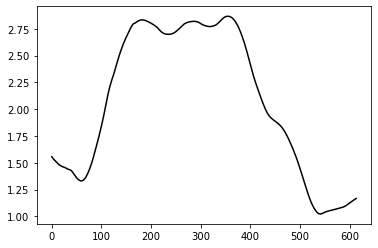

In [677]:
plt.plot(gaussian_filter1d(center_right_pos[19], 2), 'k')
#plt.plot(gaussian_filter1d(center_right_pos[1]))
#plt.plot(gaussian_filter1d(center_right_pos[13], 2), 'k')

# plt.plot(gaussian_filter1d(center_right_pos[15], 2), 'k')
# plt.plot(gaussian_filter1d(center_left_pos[1], 2), 'r')
#plt.plot(gaussian_filter1d(center_left_pos[0], 2), 'r')

In [ ]:
# Need to isolate the portion of the activity near the rapid transition in position

In [624]:
right_trajectories = []
left_trajectories = []

for idx in good_right_transitions:
    x1 = np.squeeze(gaussian_filter1d(center_right_pos[idx], 2))
    dx1 = np.abs(np.diff(x1))
    start_idx = np.argmax(dx1) - 100
    end_idx = np.argmax(dx1) + 100
    right_trajectories.append(center_right_transitions[idx][start_idx:end_idx, :])
    
for idx in good_left_transitions:
    x1 = np.squeeze(gaussian_filter1d(center_left_pos[idx], 2))
    dx1 = np.abs(np.diff(x1))
    start_idx = np.argmax(dx1) - 100
    end_idx = np.argmax(dx1) + 100
    left_trajectories.append(center_left_transitions[idx][start_idx:end_idx, :])
    

In [625]:
from sklearn.preprocessing import StandardScaler

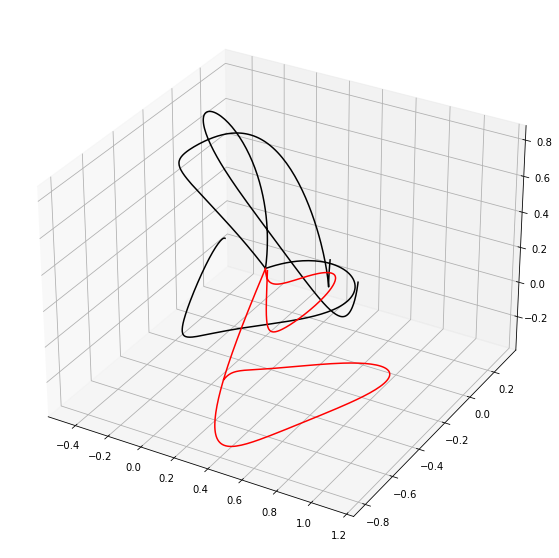

In [639]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for trajectory in [right_trajectories[0], right_trajectories[2], right_trajectories[3]]:
    trajectory = dcamodel.transform(trajectory)
    trajectory = StandardScaler().fit_transform(trajectory)
    trajectory = gaussian_filter1d(trajectory, 20, axis=0)    
    # Translate to 0
    trajectory -= trajectory[0]
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'k')

for trajectory in left_trajectories:
    trajectory = dcamodel.transform(trajectory)
    trajectory = StandardScaler().fit_transform(trajectory)
    trajectory = gaussian_filter1d(trajectory, 20, axis=0)    
    # Translate to 0
    trajectory -= trajectory[0]
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'r')
